# MaxBlue Algorithm for Determining Basketball Winners

Hypothesis: in a match up between two teams, the bluest team will win. This will be the basis for my bracket picks.

## Contents
- [Data collection](#data_collection)
    - [Scraping the page](#scraping_the_page)
    - [Saving the images](#saving_the_images)
    - [Calculating the blue](#calculating_the_blue)
- [Visualizations](#visualizations)
    - [Maximum blue value](#maximum_blue_value)
    - [Maximum blue value, penalized](#maximum_blue_value_penalized)
    - [Mean blue value](#mean)
    - [Mean blue value, penalized](#mean_penalized)
    - [Median blue value](#median)
    - [Median blue value, penalized](#median_penalized)
- [Conclusion](#conclusion)
    - [Feature Selection Sunday](#selection_sunday)
    - [Bracket](#bracket)

In [1]:
from bs4 import BeautifulSoup
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests

plt.rcParams['figure.figsize'] = [10, 6]

<a id='data_collection'></a>
## Data collection

In an attempt at keeping this hot mess of an analysis standardized, all the images come from the exact same place: the ESPN website.

<a id='scraping_the_page'></a>
### Scraping the page

Each school listed in the bracket is a link that contains the school's name and ID. We can grab all these links, and then store the names and IDs.

In [2]:
# constants

HEADERS = {
"User-Agent":'Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/59.0.3071.115 Safari/537.36'
}

SITE = "http://www.espn.com/mens-college-basketball/tournament/bracket"
LOGO_DIR = "logos/"
IMAGE_LINK = "https://a.espncdn.com/i/teamlogos/ncaa/500/{}.png"
PIXEL_FILE = "pixels.csv"

if not os.path.exists(LOGO_DIR):
    os.mkdir(LOGO_DIR)

In [3]:
# read the bracket, and find each team
page = requests.get(SITE, headers=HEADERS)
soup = BeautifulSoup(page.content, "lxml")
tags = soup.find_all("dt")

In [4]:
# parse the html to get team info
# pls don't read this disgusting code

team_map = dict()
for tag in tags:
    
    string = str(tag)
    if (len(string) < 10):
        continue
        
    [team1, team2] = string.split("<br/>")
    
    # team1
    seed = team1[4:].split(" ")[0]
    url = team1.split("team/_/id/")[1]
    id_ = url.split("/")[0]
    name = url.split('">')[1].split("<")[0]
    team_map[name] = (seed, id_)
    
    # team2
    seed = team2.split(" ")[0]
    url = team2.split("team/_/id/")[1]
    id_ = url.split("/")[0]
    name = url.split('">')[1].split("<")[0]
    team_map[name] = (seed, id_)

<a id='saving_the_images'></a>
### Saving the images

Use the ID to access the team logo, and save that locally.

In [5]:
for (team_name, (seed, team_id)) in team_map.items():        
    logo_url = IMAGE_LINK.format(team_id)
    file_name = LOGO_DIR + team_name + ".png"
    with open(file_name, "wb") as f:
        response = requests.get(logo_url)
        pic = response.content
        f.write(pic)

<a id='calculating_the_blue'></a>
### Calculating the blue

Use `opencv2` to read in the images. Each pixel has a red, green, blue, and alpha value. Store these in a CSV.

In [6]:
# function to calculate the blueness
def get_blue(image_file):
    
    # convert to pixel list and filter out see-through pixels
    image = cv2.imread(image_file, cv2.IMREAD_UNCHANGED)
    n_pixels = image.shape[0] * image.shape[1]
    all_pixels = np.reshape(image, (n_pixels, 4))
    pixels = np.array([p for p in all_pixels if p[3] != 0])
    
    # get the max blue value (scalar)
    b_max = max(pixels[:, 0])
    b_maxes = np.array([p for p in all_pixels if p[0] == b_max])
    g_max_avg = np.average(b_maxes[:, 1])
    r_max_avg = np.average(b_maxes[:, 2])
    
    # and the mean color (list)
    bgra_mean = np.average(pixels, axis=0)
    
    # and the median color (list)
    bgra_median = np.median(pixels, axis=0)
    
    return [b_max, g_max_avg, g_max_avg], bgra_mean, bgra_median    

In [7]:
# save the blue info

out = ["team,seed,r_max,g_max,b_max,r_mean,g_mean,b_mean,r_med,g_med,b_med"]
for (team_name, (seed, team_id)) in team_map.items():

    # files
    image_file = LOGO_DIR + team_name + ".png"
    max_file = LOGO_DIR + team_name + "-max.png"
    mn_file = LOGO_DIR + team_name + "-mean.png"
    md_file = LOGO_DIR + team_name + "-median.png"

    # calculate blueness
    bgra_max, bgra_mean, bgra_median = get_blue(image_file)
    [b_max, g_max, r_max] = bgra_max
    [b_mn, g_mn, r_mn, a_mn] = bgra_mean
    [b_md, g_md, r_md, a_md] = bgra_median

    # save pixels
    row = ",".join([
        team_name, seed, 
        str(r_max), str(g_max), str(b_max),
        str(r_mn), str(g_mn), str(b_mn),
        str(r_md), str(g_md), str(b_md)])
    out.append(row)

    # save color blocks--
    # this is not at all necessary for the analysis, but i like to look at them

    def save_color_block(file, color):
        color_block = np.zeros((100, 100, 4), dtype=np.uint8)
        color_block[:, :] = color
        cv2.imwrite(file, color_block)

    save_color_block(max_file, [b_max, 0, 0, 255])
    save_color_block(mn_file, bgra_mean)
    save_color_block(md_file, bgra_median)
    
with open(PIXEL_FILE, "w") as f:
    csv = "\n".join(out)
    f.write(csv)

<a id='visualizations'></a>
## Visualizations

"MaxBlue" is a little ambiguous, so let's look at several different ways of calculating it.

In [8]:
plt.rcParams['figure.figsize'] = [10, 6]
df = pd.read_csv(PIXEL_FILE)
df["seed"] = df["seed"].astype(int)
df.head()

,team,seed,r_max,g_max,b_max,r_mean,g_mean,b_mean,r_med,g_med,b_med
0,BEL,11,254.999643,254.999643,255,161.571232,125.746369,152.820584,230.0,68.0,117.0
1,TEM,11,255.000000,255.000000,255,196.945403,68.768823,104.959586,178.0,8.0,56.0
2,NCCU,16,255.000000,255.000000,255,158.993490,142.292741,147.590061,159.0,161.0,164.0
3,NDSU,16,255.000000,255.000000,255,91.691280,128.851433,61.555582,0.0,87.0,61.0
4,ASU,11,0.000000,0.000000,60,196.955922,103.316853,51.170241,176.0,68.0,54.0


 <a id='maximum_blue_value'></a>
### Maximum blue value

Each pixel has a blue value. Simply take the highest blue value from each logo. (This leads to a lot of ties at the maxed out value of 255, because white is represented as [255, 255, 255].)

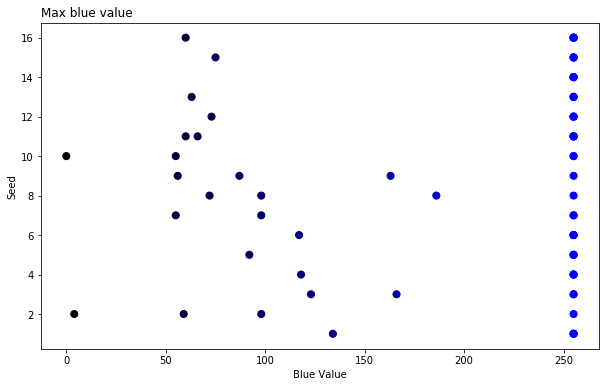

In [10]:
colors_max = np.array([[0, 0, row["b_max"]] for i, row in df.iterrows()]) / 255
plt.scatter(df["b_max"], df["seed"], c=colors_max, s=50)
plt.title("Max blue value", loc="left")
plt.xlabel("Blue Value")
plt.ylabel("Seed")
plt.show()

<a id='maximum_blue_value_penalized'></a>
### Maximum blue value, penalized

Take all pixels that have the max blue value. Find the mean red value and the mean green value. Subtract these off from the max blue value. (Here, the ties are shifted to -255.)

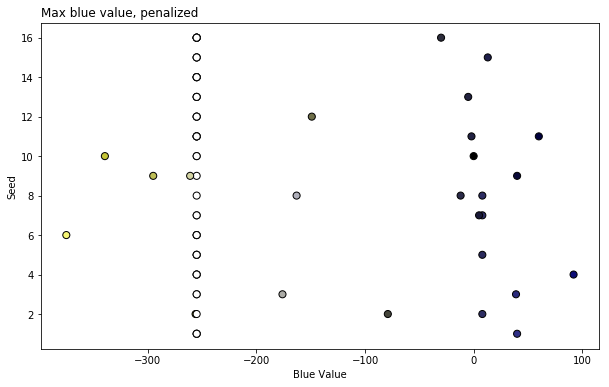

In [11]:
df["b_max_pen"] = df["b_max"] - (df["r_max"] + df["g_max"])
colors_max = np.array([[row["r_max"], row["g_max"], row["b_max"]] for i, row in df.iterrows()]) / 255
plt.scatter(df["b_max_pen"], df["seed"], c=colors_max, s=50, edgecolors=(0, 0, 0, 1))
plt.title("Max blue value, penalized", loc="left")
plt.xlabel("Blue Value")
plt.ylabel("Seed")
plt.show()

 <a id='mean'></a>
### Mean blue value

Take the average of all the blue values in the logo.

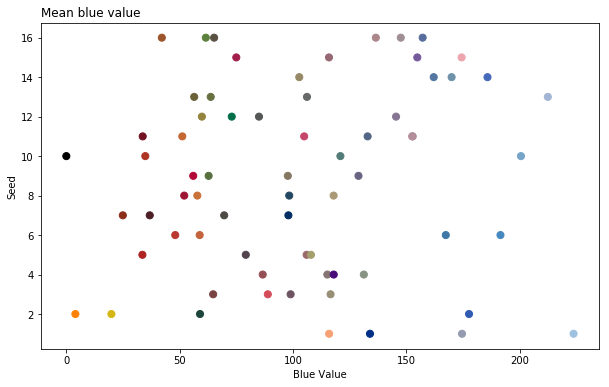

In [12]:
# ah yes, the hideous pandas syntax that we know and hate (row[["r_mean", "g_mean", "b_mean"]] gives an error)
colors_mean = np.array([[row["r_mean"], row["g_mean"], row["b_mean"]] for i, row in df.iterrows()]) / 255
plt.scatter(df["b_mean"], df["seed"], c=colors_mean, s=50)
plt.title("Mean blue value", loc="left")
plt.xlabel("Blue Value")
plt.ylabel("Seed")
plt.show()

 <a id='mean_penalized'></a>
### Mean blue value, penalized

Take the average of all the blue values in the logo, and subtract off the mean red value and mean green value.

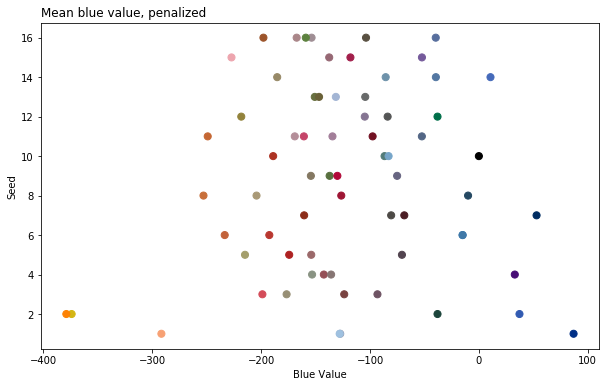

In [13]:
df["b_mean_pen"] = df["b_mean"] - (df["r_mean"] + df["g_mean"])
plt.scatter(df["b_mean_pen"], df["seed"], c=colors_mean, s=50)
plt.title("Mean blue value, penalized", loc="left")
plt.xlabel("Blue Value")
plt.ylabel("Seed")
plt.show()

 <a id='median'></a>
### Median blue value

Take the median of all the blue values in the logo.

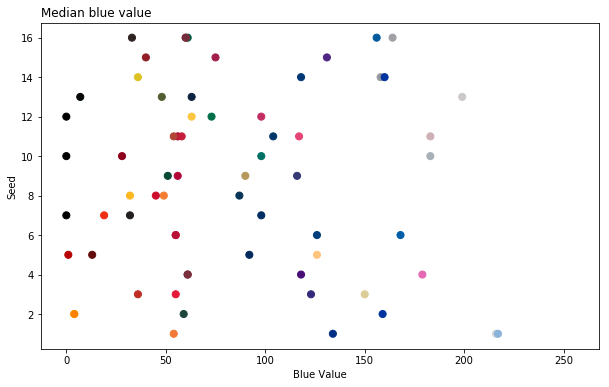

In [14]:
colors_med = np.array([[row["r_med"], row["g_med"], row["b_med"]] for i, row in df.iterrows()]) / 255
plt.scatter(df["b_med"], df["seed"], c=colors_med, s=50)
plt.title("Median blue value", loc="left")
plt.xlabel("Blue Value")
plt.ylabel("Seed")
plt.show()

 <a id='median_penalized'></a>
### Median blue value, penalized

Take the median of all the blue values in the logo, and subtract off the median red value and median green value.

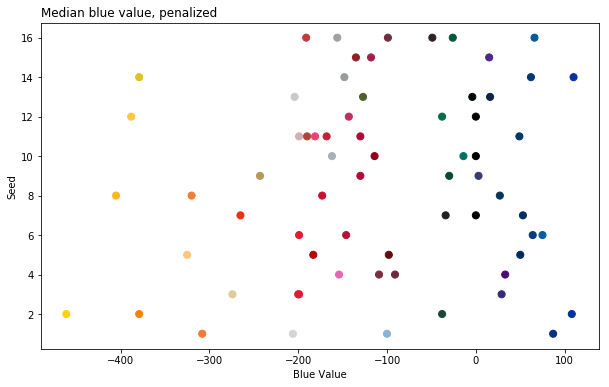

In [15]:
df["b_med_pen"] = df["b_med"] - (df["r_med"] + df["g_med"])
plt.scatter(df["b_med_pen"], df["seed"], c=colors_med, s=50)
plt.title("Median blue value, penalized", loc="left")
plt.xlabel("Blue Value")
plt.ylabel("Seed")
plt.show()

<a id='conclusion'></a>
## Conclusion

This has been a journey. Am I more knowledgeable about basketball than before? No. But am I more knowledgeable about data science than before? Also no.

In [17]:
rankings = df[["seed", "team", "b_mean_pen"]].sort_values("b_mean_pen", ascending=False)
rankings.to_csv("rankings.csv", index=False)

In [18]:
def winner(seed1, seed2):
    sub = df[["seed", "b_mean_pen", "team"]]
    print(sub[sub["seed"] == seed1])
    print(sub[sub["seed"] == seed2])
    return
    
# winner(2, 4)

###### <a id='selection_sunday'></a>
### Feature selection Sunday

I am wildly proud of the above heading. Please take a moment to enjoy it. Anyway, based on the five measures of blueness, it seems that mean blue value, penalized, has the strongest correlation with seed, so that's how I'll determine winners.

<a id='bracket'></a>
### Bracket

Aaaand here's my filled out bracket:

<img src='bracket.jpg'>